In [1]:
#Import
import pandas as pd
import sqlite3
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import math

In [2]:
from scipy import stats

In [ ]:
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker

# <font color='green'> Project Overview
   

In order to deliver the best possible product to the executives at Northwin Trading company, this project is split up into an analysis of 4 different parts of their buisness:
-  Discounts
-  Employees
-  Shipping Companies
-  Customer Regions

Below, I briefly summarize my approach to each aspect of the business|

**Discounts**

The main thing I was interested in determining is the effect of discounts on sales order quantities. In this section, I test the effect of discounts at several different levels. First, I test if discounts affect product quantities ordered. I.e. if a customer is purchasing a given product at a discount, are they more likely to purchase more of said product? 

Then, I test if discounts have an effect at the total order quantity level. I.e. if one or more products within an order contains a discount, does this increase the total quantity ordered on that order?

In the same vain, I test whether or not discounts have an effect on sales order revenue. This is essentially the same question as before, but using sales revenue instead of volume as a metric.

After testing discounted vs. non-discounted items, I test all of the different discount levels against each other. Here, I'm investigating if a larger discount translates to a larger order quantity. I.e. if a customer receives a 25% discount instead of just a 5% discount, are they more likely to purchase additional units?

**Employees**

In the employee analysis section of this project, my main aim was to evaluate the performance of the employees against one another. Unfortunately, much of the Hire Date data was corrupt, so I was unable to analyze performance changes over time for each employee. 

In order to evaluate the employees, I test each employee against each other to see if certain employees are achieving consistently higher order quantities and order sales revenues. 

I was also interested in the difference between US and UK employees, and tested to see if there was a significant difference between the performance of the two.

**Shipping Companies**

Considering the costliness and importance of shipping in this business, I wanted to analyze each of the three shipping companies for efficiency and cost. 

First, I calculate processing and shipping time for each order and divide the data up into samples for each shipping company. Then, I test each of these companies against each other to determine if any of them have significantly faster/slower processing times and shipping times. 

After performing this analysis, I also analyzed the freight costs for each of the shipping companies, compared them to each other and tried to determine if one shipping company was significantly cheaper than the others.

**Customer Regionality**

Given the global environment that Northwind Traders operates in, I wanted to analyze if certain regions had higher demand and profitability than other regions.

In order to accomplish this, I divided all of the orders up by which country the order came from. Then, I tested each region against each other to see if there were significant differences between order quantity or order revenue.

# Importing the data using sqalchemy

In [3]:
#Using sqalchemy to bring in database



engine = create_engine("sqlite:///Northwind_small.sqlite", echo=True)
Session = sessionmaker(bind=engine)
session = Session()

In [4]:
#Then we'll check the names of the tables
from sqlalchemy import inspect

inspector = inspect(engine)

print(inspector.get_table_names())

2019-04-09 19:53:20,238 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-04-09 19:53:20,239 INFO sqlalchemy.engine.base.Engine ()
2019-04-09 19:53:20,240 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-04-09 19:53:20,240 INFO sqlalchemy.engine.base.Engine ()
2019-04-09 19:53:20,241 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-04-09 19:53:20,242 INFO sqlalchemy.engine.base.Engine ()
['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']


In [5]:
#Note there are discrepancies between the table names and the ERDs. Table names are singular ERD says plural
#This is sloppy, so we'll write a quick function to put the column names in a well formatted way.

def get_columns_info(col_name):
    cols_list = inspector.get_columns(col_name)
    
    print(f"Table Name: {col_name}")
    print("")
    
    for column in cols_list:
        print("Name: {} \t Type: {}".format(column['name'], column['type']))
    
    print("")
    print("")

get_columns_info('Employee')

2019-04-09 19:53:20,261 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Employee")
2019-04-09 19:53:20,261 INFO sqlalchemy.engine.base.Engine ()
Table Name: Employee

Name: Id 	 Type: INTEGER
Name: LastName 	 Type: VARCHAR(8000)
Name: FirstName 	 Type: VARCHAR(8000)
Name: Title 	 Type: VARCHAR(8000)
Name: TitleOfCourtesy 	 Type: VARCHAR(8000)
Name: BirthDate 	 Type: VARCHAR(8000)
Name: HireDate 	 Type: VARCHAR(8000)
Name: Address 	 Type: VARCHAR(8000)
Name: City 	 Type: VARCHAR(8000)
Name: Region 	 Type: VARCHAR(8000)
Name: PostalCode 	 Type: VARCHAR(8000)
Name: Country 	 Type: VARCHAR(8000)
Name: HomePhone 	 Type: VARCHAR(8000)
Name: Extension 	 Type: VARCHAR(8000)
Name: Photo 	 Type: BLOB
Name: Notes 	 Type: VARCHAR(8000)
Name: ReportsTo 	 Type: INTEGER
Name: PhotoPath 	 Type: VARCHAR(8000)




In [6]:
table_list = inspector.get_table_names()
for table in table_list:
    get_columns_info(table)

2019-04-09 19:53:20,267 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Category")
2019-04-09 19:53:20,268 INFO sqlalchemy.engine.base.Engine ()
Table Name: Category

Name: Id 	 Type: INTEGER
Name: CategoryName 	 Type: VARCHAR(8000)
Name: Description 	 Type: VARCHAR(8000)


2019-04-09 19:53:20,269 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Customer")
2019-04-09 19:53:20,270 INFO sqlalchemy.engine.base.Engine ()
Table Name: Customer

Name: Id 	 Type: VARCHAR(8000)
Name: CompanyName 	 Type: VARCHAR(8000)
Name: ContactName 	 Type: VARCHAR(8000)
Name: ContactTitle 	 Type: VARCHAR(8000)
Name: Address 	 Type: VARCHAR(8000)
Name: City 	 Type: VARCHAR(8000)
Name: Region 	 Type: VARCHAR(8000)
Name: PostalCode 	 Type: VARCHAR(8000)
Name: Country 	 Type: VARCHAR(8000)
Name: Phone 	 Type: VARCHAR(8000)
Name: Fax 	 Type: VARCHAR(8000)


2019-04-09 19:53:20,272 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("CustomerCustomerDemo")
2019-04-09 19:53:20,272 INFO sqlalchemy.engine

In [7]:
#Let's start looking at the discounts

In [8]:
import pandas as pd
con = engine.connect()
df = pd.read_sql_query("SELECT * from OrderDetail", engine)
df.head(20)

2019-04-09 19:53:20,295 INFO sqlalchemy.engine.base.Engine SELECT * from OrderDetail
2019-04-09 19:53:20,295 INFO sqlalchemy.engine.base.Engine ()


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.00
1,10248/42,10248,42,9.8,10,0.00
2,10248/72,10248,72,34.8,5,0.00
3,10249/14,10249,14,18.6,9,0.00
4,10249/51,10249,51,42.4,40,0.00
5,10250/41,10250,41,7.7,10,0.00
6,10250/51,10250,51,42.4,35,0.15
7,10250/65,10250,65,16.8,15,0.15
8,10251/22,10251,22,16.8,6,0.05
9,10251/57,10251,57,15.6,15,0.05


In [9]:
#Create dfs for each table
dfs = []
for table in table_list:
    df = pd.read_sql_query('SELECT * from "'+table+'"', engine)
    str_to_var = table+"_df" #creates string with new df name
    exec(str_to_var + " = df") #executes a line of code, thereby creating new df with name
    dfs.append(str_to_var)

2019-04-09 19:53:20,342 INFO sqlalchemy.engine.base.Engine SELECT * from "Category"
2019-04-09 19:53:20,342 INFO sqlalchemy.engine.base.Engine ()
2019-04-09 19:53:20,344 INFO sqlalchemy.engine.base.Engine SELECT * from "Customer"
2019-04-09 19:53:20,345 INFO sqlalchemy.engine.base.Engine ()
2019-04-09 19:53:20,347 INFO sqlalchemy.engine.base.Engine SELECT * from "CustomerCustomerDemo"
2019-04-09 19:53:20,348 INFO sqlalchemy.engine.base.Engine ()
2019-04-09 19:53:20,350 INFO sqlalchemy.engine.base.Engine SELECT * from "CustomerDemographic"
2019-04-09 19:53:20,350 INFO sqlalchemy.engine.base.Engine ()
2019-04-09 19:53:20,352 INFO sqlalchemy.engine.base.Engine SELECT * from "Employee"
2019-04-09 19:53:20,352 INFO sqlalchemy.engine.base.Engine ()
2019-04-09 19:53:20,355 INFO sqlalchemy.engine.base.Engine SELECT * from "EmployeeTerritory"
2019-04-09 19:53:20,355 INFO sqlalchemy.engine.base.Engine ()
2019-04-09 19:53:20,357 INFO sqlalchemy.engine.base.Engine SELECT * from "Order"
2019-04-09 

In [10]:
#Looking at all our newly formed dataframes
dfs

['Category_df',
 'Customer_df',
 'CustomerCustomerDemo_df',
 'CustomerDemographic_df',
 'Employee_df',
 'EmployeeTerritory_df',
 'Order_df',
 'OrderDetail_df',
 'Product_df',
 'Region_df',
 'Shipper_df',
 'Supplier_df',
 'Territory_df']

In [11]:
#Preview of orderdetail data
OrderDetail_df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


#  <font color='green'> Part 1: Analyzing Discounts

Before I begin hypothesis testing, I'll need to divide the dataframe into discounts and non-discounts. Then I'll perform some very basic exploratory data analysis.

In [12]:
#Let's divide into two dfs, one with discount and one without
no_discount = OrderDetail_df[OrderDetail_df['Discount']==0]
discount = OrderDetail_df[OrderDetail_df['Discount']!=0]
discount.head(5)

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
6,10250/51,10250,51,42.4,35,0.15
7,10250/65,10250,65,16.8,15,0.15
8,10251/22,10251,22,16.8,6,0.05
9,10251/57,10251,57,15.6,15,0.05
11,10252/20,10252,20,64.8,40,0.05


In [13]:
#Creating a df to count the number of orders in each category and the mean quantity for each.
discount_counts_df = pd.DataFrame()
discount_counts_df['number_of_orders'] = OrderDetail_df.groupby('Discount')['Quantity'].count()
discount_counts_df['quantity_ordered_means'] = OrderDetail_df.groupby('Discount')['Quantity'].mean()
discount_counts_df

,number_of_orders,quantity_ordered_means
Discount,,
0.00,1317,21.715262
0.01,1,2.000000
0.02,2,2.000000
0.03,3,1.666667
0.04,1,1.000000
0.05,185,28.010811
0.06,1,2.000000
0.10,173,25.236994
0.15,157,28.382166


Here, we can see that there is not much data for discounts of 1%, 2%, 3%, 4%, or 6%. As a result, we won't draw conclusions about these categories individually. However, they will still be considered part of the entire "sample" of discounted orders.

In [14]:
# Creating our two samples to be tested
control_no_discount = OrderDetail_df[OrderDetail_df['Discount']==0]['Quantity']
experimental_discount = OrderDetail_df[OrderDetail_df['Discount']!=0]['Quantity']


In [15]:
len(experimental_discount)

838

C:\Users\Alex\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


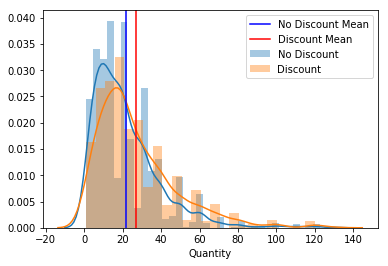

In [16]:
#Visualizing the control vs. the experimental
sns.distplot(control_no_discount, label="No Discount")
sns.distplot(experimental_discount, label="Discount")
plt.axvline(control_no_discount.mean(),0,1, color='blue', label='No Discount Mean')
plt.axvline(experimental_discount.mean(),0,1, color='red', label='Discount Mean')
plt.legend()
plt.show()

# Question 1a: Do discounts have an effect on the quantity of product ordered?

In order to make a comparison between the two means: discounted quantities ordered and non-discounted quantities ordered, I will perform a two sample welch's t-test. The welch's t-test is appropriate for samples that do not have equal variance. However, the welch's t-test relies on the underlying assumption that the data is approximately normally distributed. Below I will test our data for its normality. 

In [17]:
# Examining means beforehand
print(control_no_discount.mean())
print(experimental_discount.mean())

21.715261958997722
27.10978520286396


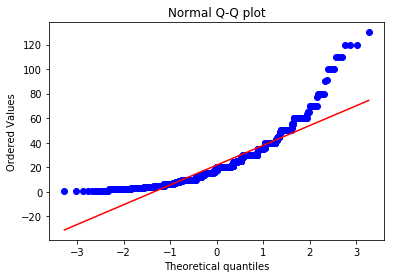

In [18]:
# Checking both experimental and control for normality
# Q-Q plot
stats.probplot(control_no_discount, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

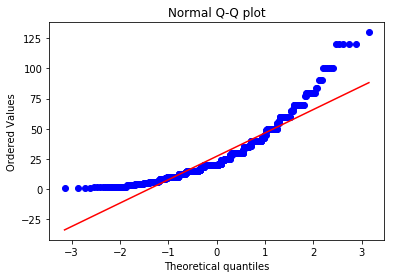

In [19]:
#Experimental Q-Q plot
stats.probplot(experimental_discount, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

In [20]:
# Testing for normality using Kolmogorov-Smirnov test.
print(stats.kstest(control_no_discount, 'norm', args=(control_no_discount.mean(), control_no_discount.std())))
print(stats.kstest(experimental_discount, 'norm', args=(experimental_discount.mean(), experimental_discount.std())))

KstestResult(statistic=0.1571445192364258, pvalue=0.0)
KstestResult(statistic=0.15266873914907575, pvalue=0.0)


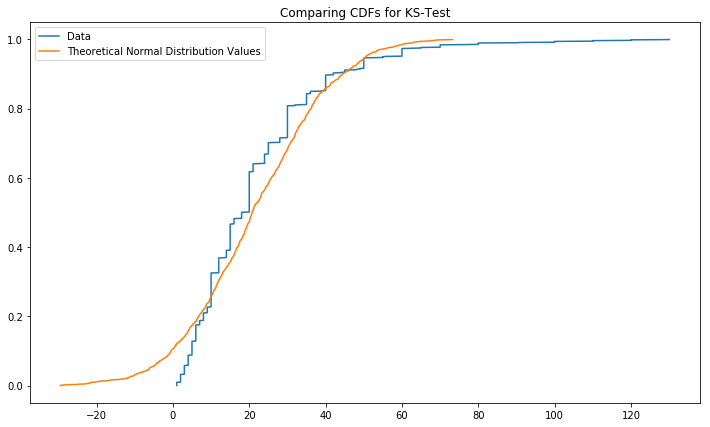

In [21]:
def ks_plot_norm(data):
    length = len(data)
    plt.figure(figsize=(12, 7))
    plt.plot(np.sort(data), np.linspace(0, 1, len(data), endpoint=False))
    plt.plot(np.sort(stats.norm.rvs(loc=data.mean(), scale=data.std(), size=len(data))), np.linspace(0, 1, len(data), endpoint=False))
    plt.legend('top right')
    plt.legend(['Data', 'Theoretical Normal Distribution Values'])
    plt.title('Comparing CDFs for KS-Test')
    
ks_plot_norm(control_no_discount)

<font color='red'> **A quick note about welch's t-test and the decision to use parametric testing instead of non-parametric testing for the duration of this project.**
   

Even though all of the tests and visualizations above seem to indicate the data is not approximately normally distributed, the sample size is large enough (>700) that the result's of a welch's t-test are still valid. After several hours of research, I've concluded that as sample size increases, meeting the normality assumption becomes less and less important to an effective t-test. Even if the underlying data is not normally distributed, the **distribution of sample means of that data is a normal distribution**, especially as the size of the sample increases. Since the t-test is a direct comparison of the two sample means, it doesn't matter that the data is skewed because the **distribution of the sample means** will be approximately normal (as long as the sample size is large enough).

Below are two articles discussing the merit of welch's t-test even when the normality assumption can not be met.

http://thestatsgeek.com/2013/09/28/the-t-test-and-robustness-to-non-normality/ <br>
http://rctdesign.org/techreports/arphnonnormality.pdf

These articles conclude that "The t-test and least-squares linear regression do not require any assumption of
Normal distribution in sufficiently large samples." Given that our sample sizes for this particular test are over 800, I believe that welch's t-test is the most effective test.

<font color='red'> **Why I don't use non-parametric testing and why I primarily use Welch's t-test throughout this project**.

Non parametric testing is typically used when the assumptions necessary to run a parametric test are not being satisfied. As discussed above and explained by the article, the normality assumption for Welch's t-test becomes less and less important as sample size rises. All of the tests performed below have sufficient sample sizes such that the Welch's t-test is still effective even without the normality assumption.

Furthermore, the results of non-parametric testing are less insightful than Welch's t-test. Welch's t-test is a comparison between two means, and if the test determines significance- this means that there is a significant difference between the two means. However, non-parametric tests simply tell the user whether or not the distribution of two independent samples are equal. 

This means that a non-parametric test could return significant results even if the two samples have exactly the same mean. If their variances differ enough, having the same mean is irrelevant to the test. Therefore, non-parametric tests do not allow the user to draw conclusions about the means. Rather, the user can only draw conclusions about whether or not the distributions are equal. 

Because I was primarily interested in a difference of means for all tests, I used Welch's t-test and simply ensured that sample sizes were large enough.

Below, I offer a quick proof of the central limit theorem showing that if we were to sample from our data 10,000 times, the distribution of sample means would be approximately normal with a mean right near our entire sample mean. 

(array([1.000e+00, 3.000e+00, 1.900e+01, 3.800e+01, 1.140e+02, 2.010e+02,
        4.090e+02, 6.080e+02, 8.390e+02, 1.069e+03, 1.154e+03, 1.224e+03,
        1.166e+03, 9.480e+02, 7.330e+02, 5.850e+02, 3.710e+02, 2.200e+02,
        1.350e+02, 8.500e+01, 3.400e+01, 2.500e+01, 9.000e+00, 6.000e+00,
        4.000e+00]),
 array([15.56  , 16.0908, 16.6216, 17.1524, 17.6832, 18.214 , 18.7448,
        19.2756, 19.8064, 20.3372, 20.868 , 21.3988, 21.9296, 22.4604,
        22.9912, 23.522 , 24.0528, 24.5836, 25.1144, 25.6452, 26.176 ,
        26.7068, 27.2376, 27.7684, 28.2992, 28.83  ]),
 <a list of 25 Patch objects>)

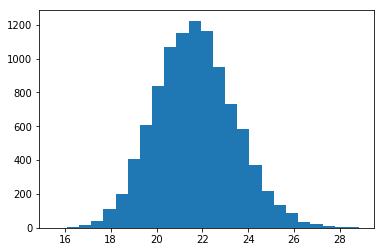

In [22]:
#Proving that the normal distribution of sample means approaches a normal distribution as number of samples increases.
mean_list = []
for i in range(10000):
    control_sample = control_no_discount.sample(100, replace=True)
    sample_mean = control_sample.mean()
    mean_list.append(sample_mean)
    
plt.hist(mean_list, bins=25)



# Stating Null and Alternative Hypotheses

In this particular testing context, we are looking at a sample of 838 "product orders" ordered without a discount and a sample of 838 "product orders" ordered with a discount. Note that many orders can have multiple "product orders" within them, and discounts are applied on a product by product basis.

For example, a customer might order 10 boxes of clam chowder, 15 tins of coffee, and 12 chocolate bars all within the same order. Each of these 3 items is considered a different "product order" for purposes of this analysis. These seems like a logical method for analysis because discounts are applied on a product-by-product basis.

This first test is simply examining whether there is a statistically significant difference between the average quantity of product ordered when that product is discounted and the average quantity of product ordered when that product is not discounted. There are many orders with multiple products per order, which somewhat complicates this analysis. Later on I will examine if orders which contain discounted products tend to produce larger overall order quantities than orders without any discounted products.

H$_0$: $\mu_{Discount Product Quantities}$ ≤ $\mu_{No Discount Product Quantities}$ <br>
H$_a$: $\mu_{Discount Product Quantities}$ > $\mu_{No Discount Product Quantities}$

The null hypothesis is that discounted quantities will be less than or equal to non-discounted quantities, and the alternative hypothesis is that discounted quantities are greater than non-discounted quantities. This is a one-tailed-test, because I am only interested in determining if discounted quantities are HIGHER than non-discounted quantities

This test will be completed at a significance level(alpha) of 5%. Meaning that if our p-value for a one-tailed test is below 0.05, we will reject the null hypothesis.

In [23]:
# Let's run a t-test to compare the two means for stasitical significance. 


As I was doing research about welch's t-test, I learned that the test performs best when sample sizes are roughly equal between the two samples. Normally this is not a huge issue, but since we have almost double the observations in one group I will sub-sample from the larger sample. Currently, the no_discount sample contains 1317 observations, but the discount sample contains only 838. In order to correct this to get the best results from welch's t-test, I will randomly sample 838 observations from the no_discount observations. This will equalize the sample sizes before the test.

In [24]:
from random import sample
np.random.seed(1)
control_no_discount_resized = control_no_discount.sample(len(experimental_discount))
control_no_discount_resized.mean()

21.836515513126493

In [25]:
t_stat, p = stats.ttest_ind(control_no_discount_resized, experimental_discount, equal_var=False) 
#equal_var=False establishes it as Welch's t-test

#Note that this is the results for a two tailed test

print(f"T-Stat: {t_stat}")
print(f"P-value: {p/2}") # Dividing p by 2 because this is a one-tailed test and stats.ttest_ind calculates for two-tailed. 

T-Stat: -5.584293660414214
P-value: 1.3715710857741735e-08


**Results**

Since our p-value is well below 0.05, we **reject the null hypothesis that discounted product order quantities are less than or equal to non-discounted product order quantities**. This means that discounts have a statistically significant effect on product quantities ordered!

**Effect Size**

Now that we've determined that an effect exists, next we will use effect size to determine the size of that effect. I present below the effect size in quantity as well as in Cohen's d.

In [26]:
# Add in cohen's d for effect size here.
def Cohen_d(group1, group2):

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled variance
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [27]:
effect_size_quantity = round(experimental_discount.mean() - control_no_discount.mean(),2)
effect_size_cohen = round(Cohen_d(experimental_discount, control_no_discount),3)


print(f"Effect Size in Quantity: {effect_size_quantity}")
print(f"Effect Size Cohen's d: {effect_size_cohen}")


Effect Size in Quantity: 5.39
Effect Size Cohen's d: 0.286


This means that on average, customers order 5.4 more items of a product when the item is discounted vs. when it is not-discounted. A cohen's d effect size of 0.286 indicates a small to medium effect.

# Question 1b: Do discounts have an effect on total order quantity?
H$_0$: $\mu_{Discount Order Quantities}$ ≤ $\mu_{No Discount Order Quantities}$ <br>
H$_a$: $\mu_{Discount Order Quantities}$ > $\mu_{No Discount Order Quantities}$

In [28]:
# Using nested SQL query to get the data we need. The query nested farthest in sums the quantities for each order 
# by summing product quantities for each order, pulled in from the OrderDetails table. It also calculates the max 
# and min discount for each order
# The outer query takes the items from the created table for orders where there was any discount (maxdiscount > 0)

discount_query = """SELECT OrderId, 
                              OrderQuantity, 
                              MaxDiscount, 
                              MinDiscount,
                              GrossRevenue
                       FROM (
                            SELECT OrderId,
                                   SUM(Quantity) AS OrderQuantity,
                                   MAX(Discount) AS MaxDiscount,
                                   MIN(Discount) AS MinDiscount,
                                   Sum(GrossRevenue) AS GrossRevenue
                            FROM (
                                 SELECT OrderId AS OrderId,
                                        Quantity AS Quantity,
                                        Discount AS Discount,
                                        ((UnitPrice)*Quantity)*(1-Discount) AS GrossRevenue
                                 FROM OrderDetail 
                                 )
                            GROUP BY OrderId
                            )
                       WHERE MaxDiscount > 0
                       GROUP BY OrderId"""
no_discount_query = """SELECT OrderId, 
                              OrderQuantity, 
                              MaxDiscount, 
                              MinDiscount,
                              GrossRevenue
                       FROM (
                            SELECT OrderId,
                                   SUM(Quantity) AS OrderQuantity,
                                   MAX(Discount) AS MaxDiscount,
                                   MIN(Discount) AS MinDiscount,
                                   Sum(GrossRevenue) AS GrossRevenue
                            FROM (
                                 SELECT OrderId AS OrderId,
                                        Quantity AS Quantity,
                                        Discount AS Discount,
                                        ((UnitPrice)*Quantity)*(1-Discount) AS GrossRevenue
                                 FROM OrderDetail 
                                 )
                            GROUP BY OrderId
                            )
                       WHERE MaxDiscount == 0
                       GROUP BY OrderId"""

discount_order_df = pd.read_sql_query(discount_query, engine)
no_discount_order_df = pd.read_sql_query(no_discount_query, engine)


2019-04-09 19:53:21,909 INFO sqlalchemy.engine.base.Engine SELECT OrderId, 
                              OrderQuantity, 
                              MaxDiscount, 
                              MinDiscount,
                              GrossRevenue
                       FROM (
                            SELECT OrderId,
                                   SUM(Quantity) AS OrderQuantity,
                                   MAX(Discount) AS MaxDiscount,
                                   MIN(Discount) AS MinDiscount,
                                   Sum(GrossRevenue) AS GrossRevenue
                            FROM (
                                 SELECT OrderId AS OrderId,
                                        Quantity AS Quantity,
                                        Discount AS Discount,
                                        ((UnitPrice)*Quantity)*(1-Discount) AS GrossRevenue
                                 FROM OrderDetail 
                                 )
           

In [29]:
discount_order_df.head()

,OrderId,OrderQuantity,MaxDiscount,MinDiscount,GrossRevenue
0,10250,60,0.15,0.0,1552.60
1,10251,41,0.05,0.0,654.06
2,10252,105,0.05,0.0,3597.90
3,10254,57,0.15,0.0,556.62
4,10258,121,0.20,0.2,1614.88


In [30]:
# T-test for order quantities 
# Note that the sample sizes are similar enough that they do not require rescaling.
x1d = discount_order_df['OrderQuantity']
x2nd = no_discount_order_df['OrderQuantity']
t_stat, p = stats.ttest_ind(x1d, x2nd, equal_var=False)

print(f"T-Stat: {t_stat}")
print(f"P-value: {p/2}") # Dividing p by 2 because this is a one-tailed test and stats.ttest_ind calculates for two-tailed. 

T-Stat: 5.886184782446325
P-value: 2.925338907945559e-09


**Results**

Since our p-value is well below 0.05, we **reject the null hypothesis quantities for orders which contain a discount are less than or equal to quantities for orders which do not contain a discount**. This means that discounts have a statistically significant effect on orders' total quantity. 

**Effect Size**

Now that we've determined that an effect exists, next we will use effect size to determine the size of that effect. I present below the effect size in quantity as well as in Cohen's d.

In [31]:
effect_size_quantity = round(x1d.mean() - x2nd.mean(),2)
effect_size_cohen = round(Cohen_d(x1d, x2nd),3)


print(f"Effect Size in Quantity: {effect_size_quantity}")
print(f"Effect Size Cohen's d: {effect_size_cohen}")

Effect Size in Quantity: 20.5
Effect Size Cohen's d: 0.412


This means that on average, customers order 20.5 more items on an order when order contains a discount vs. when an order does not contain a discount. A cohen's d effect size of 0.412 indicates a medium effect.

# Question 1c: Do discounts have an effect on total order revenue??
H$_0$: $\mu_{Discount Order Revenue}$ ≤ $\mu_{No Discount Order Revenue}$ <br>
H$_a$: $\mu_{Discount Order Revenue}$ > $\mu_{No Discount Order Revenue}$

In [211]:
# T-test for order revenue totals
# Note that the sample sizes are similar enough that they do not require rescaling.
x1d = discount_order_df['GrossRevenue']
x2nd = no_discount_order_df['GrossRevenue']
t_stat, p = stats.ttest_ind(x1d, x2nd, equal_var=False)

print(f"T-Stat: {t_stat}")
print(f"P-value: {p/2}") # Dividing p by 2 because this is a one-tailed test and stats.ttest_ind calculates for two-tailed. 

T-Stat: 2.5406944773230715
P-value: 0.005626924599663584


**Results**

Since our p-value is well below 0.05, we **reject the null hypothesis revenue for orders which contain a discount are less than or equal to revenue for orders which do not contain a discount**. This means that discounts have a statistically significant effect on orders' revenue. This result is not surprising, because revenue and quantity ordered are very highly correlated. However, this analysis suggests that offering discounts doesn't have an adverse effect on revenue because there is still a statistically significant difference between discounted revenue and non-discounted revenue.

**Effect Size**

Now that we've determined that an effect exists, next we will use effect size to determine the size of that effect. I present below the effect size in quantity as well as in Cohen's d.

In [212]:
effect_size_quantity = round(x1d.mean() - x2nd.mean(),2)
effect_size_cohen = round(Cohen_d(x1d, x2nd),3)


print(f"Effect Size in Quantity: {effect_size_quantity}")
print(f"Effect Size Cohen's d: {effect_size_cohen}")

Effect Size in Quantity: 327.02
Effect Size Cohen's d: 0.178


This means that on average, orders which contain a discount have greater sales revenue by an average of $327.02. An effect size of 0.18 indicates a small effect size.

# Question 1d: Does discount level(5%, 10%, etc.) have an effect on quantity ordered? In other words, is there a significant difference between the quantity of product ordered at a 5% discount and the quantity of product ordered at a 10% discount?

In [33]:
import itertools
#First, I have to create different combinations to test. I will include 0 discount in this combination set 
#so we can see if each individual level of discount is significant
discount_levels = np.array([0, 0.05, 0.10, 0.15, 0.20, 0.25])
discount_combinations = itertools.combinations(discount_levels, 2)

#Creating a dataframe to put the output of our test in
discount_combo_df = pd.DataFrame(columns = ['Discount_1','Discount_2','p-value','Reject Null?', 'Effect Size', 'Cohens d'])

for combo in discount_combinations:
    
    samp1_control = OrderDetail_df[OrderDetail_df['Discount']==combo[0]]['Quantity']
    samp2_experimental = OrderDetail_df[OrderDetail_df['Discount']==combo[1]]['Quantity']
    
    t_stat, p_val = stats.ttest_ind(samp2_experimental, samp1_control)
    effect_size_quantity = round(samp2_experimental.mean() - samp1_control.mean(),2)
    effect_size_cohen = round(Cohen_d(samp2_experimental, samp1_control),3)
    
    discount_combo_df = discount_combo_df.append({'Discount_1' : str(combo[0]), 'Discount_2': str(combo[1]), 
                                                 'p-value': p_val, 'Reject Null?': "Yes, Reject" if p_val < 0.05 else "No, Fail to Reject",
                                                 'Effect Size': effect_size_quantity, 'Cohens d': effect_size_cohen}, ignore_index=True)
    

For each comparison, the null hypothesis is that there is no difference between the two levels. The alternative hypothesis is that there is a significant difference between the two discount levels in terms of the quantity ordered. 

H$_0$: $\mu_{Discount level 1 Product Quantities}$ = $\mu_{Discount level 2 Product Quantities}$ <br>
H$_a$: $\mu_{Discount level 1 Product Quantities}$ ≠ $\mu_{Discount level 2 Product Quantities}$

In [34]:
discount_combo_df

,Discount_1,Discount_2,p-value,Reject Null?,Effect Size,Cohens d
0,0.0,0.05,0.000011,"Yes, Reject",6.30,0.347
1,0.0,0.1,0.015501,"Yes, Reject",3.52,0.196
2,0.0,0.15,0.000011,"Yes, Reject",6.67,0.372
3,0.0,0.2,0.000326,"Yes, Reject",5.31,0.301
4,0.0,0.25,0.000018,"Yes, Reject",6.52,0.367
5,0.05,0.1,0.227824,"No, Fail to Reject",-2.77,-0.128
6,0.05,0.15,0.874302,"No, Fail to Reject",0.37,0.017
7,0.05,0.2,0.658742,"No, Fail to Reject",-0.99,-0.048
8,0.05,0.25,0.921297,"No, Fail to Reject",0.23,0.011
9,0.1,0.15,0.176421,"No, Fail to Reject",3.15,0.149


In [35]:
OrderDetail_df[OrderDetail_df['Discount']==0.25]['Quantity'].mean()

28.24025974025974

In [36]:
OrderDetail_df[OrderDetail_df['Discount']==0.2]['Quantity'].mean() -OrderDetail_df[OrderDetail_df['Discount']==0.25]['Quantity'].mean()

-1.2154150197628475

**Results**

Here we can see that the only null hypothesis that we are able to reject are the differences between each of the discount levels and the no discount level. This reinforces our other discount tests above.

# <font color='blue'> Part 1 Conclusion and Reccomendations: Discounts

**Findings**

Based on the results to hypothesis testing, I conclude that discounts do have a significant effect on product quantity, order quantity, and order sales revenue. Furthermore, there is no statistically significant difference between different discount amounts. In other words, having a larger discount doesn't cause an order to be larger, instead it is merely the presence of ANY discount that affects order quantity and sales revenue.

**Recommendations**

I reccomend expanding the discount program and dialing down discounts of more than 10%. It seems that the incentive of any discount is enough to drive up quantities, and larger discounts will lead to lesser profits. In particular, Northwind should target customers who are not currently receiving a lot of discounts, and begin offering them minor discounts on all products.

#  <font color='green'> Part 2: Analyzing Employees

Having come to a conclusion on discounts, I'll now begin to examine employee performance. The first question I'm interested in is whether or not USA and UK employees perform differently. To test this, I'll compare the ORDER quantity for orders handled by USA sales reps to ORDER quantity for orders handled by UK sales reps. This will also take some nested SQL statements to get the data I need. Note that the metric we're using the evaluate employee performance is the total quantity of all products on a single order. Because we're considering each employee as a group, this analysis could potentially be biased by extreme outliers within each group. To account for this, I will do an individual employee analysis later.

In [37]:
# Using SQL statements to get a table showing order, order quantity total, and the employee region for each order
employee_query = """SELECT asdf.EmployeeID,
                              asdf.OrderQuantity,
                              asdf.OrderID,
                              asdf.GrossRevenue,
                              e.LastName,
                              e.Country
                              
                    FROM (
                        SELECT o.EmployeeId AS EmployeeID,
                            o.Id as OrderID,
                            SUM(od.Quantity) AS OrderQuantity,
                            SUM((od.Quantity*od.UnitPrice)*(1-od.Discount)) as GrossRevenue
                            FROM [Order] o
                            INNER JOIN OrderDetail od ON o.Id == od.OrderId
                                
                            GROUP BY o.Id
                            ) asdf
                    INNER JOIN Employee e ON e.Id = asdf.EmployeeID
                       
                    """

In [168]:
# Put that query into a dataframe and preview it
employee_orders_df = pd.read_sql_query(employee_query, engine)
employee_orders_df

2019-04-09 20:59:22,964 INFO sqlalchemy.engine.base.Engine SELECT asdf.EmployeeID,
                              asdf.OrderQuantity,
                              asdf.OrderID,
                              asdf.GrossRevenue,
                              e.LastName,
                              e.Country
                              
                    FROM (
                        SELECT o.EmployeeId AS EmployeeID,
                            o.Id as OrderID,
                            SUM(od.Quantity) AS OrderQuantity,
                            SUM((od.Quantity*od.UnitPrice)*(1-od.Discount)) as GrossRevenue
                            FROM [Order] o
                            INNER JOIN OrderDetail od ON o.Id == od.OrderId
                                
                            GROUP BY o.Id
                            ) asdf
                    INNER JOIN Employee e ON e.Id = asdf.EmployeeID
                       
                    
2019-04-09 20:59:22,964 INFO sqla

,EmployeeID,OrderQuantity,OrderID,GrossRevenue,LastName,Country
0,5,27,10248,440.0000,Buchanan,UK
1,6,49,10249,1863.4000,Suyama,UK
2,4,60,10250,1552.6000,Peacock,USA
3,3,41,10251,654.0600,Leverling,USA
4,4,105,10252,3597.9000,Peacock,USA
5,3,102,10253,1444.8000,Leverling,USA
6,5,57,10254,556.6200,Buchanan,UK
7,9,110,10255,2490.5000,Dodsworth,UK
8,3,27,10256,517.8000,Leverling,USA
9,4,46,10257,1119.9000,Peacock,USA


# Question 2a: Do employees from USA and UK have significantly different average order quantities?
H$_0$: $\mu_{USA Employee Order Quantities}$ = $\mu_{UK Employee Order Quantities}$ <br>
H$_a$: $\mu_{USA Employee Order Quantities}$ ≠ $\mu_{UK Employee Order Quantities}$

In [39]:
USA_emp_orders = employee_orders_df[employee_orders_df['Country']=="USA"]
print(len(USA_emp_orders))
UK_emp_orders = employee_orders_df[employee_orders_df['Country']=="UK"]
print(len(UK_emp_orders))

606
224


Looks good! Now let's divide it up into two samples which we will use a welch's t-test for. Since there are enough observations in both, we will run a welch's t-test using all of the data. Further reading leads me to believe that the welch's t is a robust test even when we have a seemingly large difference between the size of the two samples.

In [40]:
USA_order_quants = USA_emp_orders['OrderQuantity']
UK_order_quants = UK_emp_orders['OrderQuantity']

In [41]:
t_stat, p = stats.ttest_ind(UK_order_quants, USA_order_quants, equal_var=False)

print(f"T-Stat: {t_stat}")
print(f"P-value: {p}") 

T-Stat: 0.05689403051492102
P-value: 0.95465909347931


In [42]:
print(USA_emp_orders['OrderQuantity'].mean())
print(UK_emp_orders['OrderQuantity'].mean())

61.76567656765677
61.995535714285715


**Results**

With such a high p-value value, we cannot reject the null hypothesis and for this reason it appears that there is no statistically significant difference between USA and UK employees on the metric of order quantity. 

# Question 2b: Do employees from USA and UK have significantly different average order gross revenues?

In [43]:
USA_order_revs = USA_emp_orders['GrossRevenue']
UK_order_revs = UK_emp_orders['GrossRevenue']

In [44]:
# Welch's t-test again
t_stat, p = stats.ttest_ind(UK_order_revs, USA_order_revs, equal_var=False)

print(f"T-Stat: {t_stat}")
print(f"P-value: {p}") 

T-Stat: 0.12383782386232144
P-value: 0.9015080381474145


In [45]:
print(USA_emp_orders['GrossRevenue'].mean())
print(UK_emp_orders['GrossRevenue'].mean())

1520.1507029702977
1538.3112209821425


**Results**

With such a high p-value value, we cannot reject the null hypothesis and for this reason it appears that there is no statistically significant difference between USA and UK employees on the metric of order revenue.

# Question 2c: Are there significant differences between two individual employees for order quantity?

Here, I'll test whether or not there exist significant differences between any two set of employees. This test will help identify if certain employees are excelling and if there are large, significant gaps in between certain pairs of employees. 

In [163]:
# Now we'll see if there's any significant differecnes between the employees
import itertools
#First, I have to create different combinations to test. I will include 0 discount in this combination set 
#so we can see if each individual level of discount is significant
employee_numbers = np.array([1,2,3,4,5,6,7,8,9])
employee_combinations = itertools.combinations(employee_numbers, 2)

#Creating a dataframe to put the output of our test in
employee_combo_df = pd.DataFrame(columns = ['Employee 1','Employee 2','p-value','Reject Null?', 'Effect Size', 'Cohens d'])

for combo in employee_combinations:
    
    samp1_control = employee_orders_df[employee_orders_df['EmployeeID']==combo[0]]['OrderQuantity']
    samp2_experimental = employee_orders_df[employee_orders_df['EmployeeID']==combo[1]]['OrderQuantity']
    
    t_stat, p_val = stats.ttest_ind(samp2_experimental, samp1_control)
    effect_size_quantity = round(samp2_experimental.mean() - samp1_control.mean(),2)
    effect_size_cohen = round(Cohen_d(samp2_experimental, samp1_control),3)
    
    p_val = p_val / 2 #for one sided test
    
    employee_combo_df = employee_combo_df.append({'Employee 1' : str(combo[0]), 'Employee 2': str(combo[1]), 
                                                 'p-value': p_val, 'Reject Null?': "Yes, Reject" if p_val < 0.05 else "No, Fail to Reject",
                                                 'Effect Size': effect_size_quantity, 'Cohens d': effect_size_cohen}, ignore_index=True)
    

In [164]:
employee_combo_df

,Employee 1,Employee 2,p-value,Reject Null?,Effect Size,Cohens d
0,1,2,0.474878,"No, Fail to Reject",-0.44,-0.009
1,1,3,0.394345,"No, Fail to Reject",-1.69,-0.034
2,1,4,0.454110,"No, Fail to Reject",-0.70,-0.014
3,1,5,0.163762,"No, Fail to Reject",8.77,0.175
4,1,6,0.058875,"No, Fail to Reject",-10.87,-0.239
5,1,7,0.443446,"No, Fail to Reject",1.13,0.021
6,1,8,0.144140,"No, Fail to Reject",-6.66,-0.142
7,1,9,0.435460,"No, Fail to Reject",-1.42,-0.029
8,2,3,0.430204,"No, Fail to Reject",-1.25,-0.024
9,2,4,0.484648,"No, Fail to Reject",-0.27,-0.005


**Results**

Here we can see that between most pairs of employees, there are no significant differences in the order quantities they are able to produce. However, between employee 5 and employee 6  (Steven Buchanan and Michael Suyama) there is a significant difference and between 5 and 8  (Steven Buchanan and Laura Callahan) there is a significant difference. For both pairs, we reject the null hypothesis that there is no difference in order quantity between the two employees. Below, We will visualize some of this employee data to clarify the results

In [166]:
# Creating a dataframe to get the mean order quantities for each employee
sum_employee_orders_df = employee_orders_df.groupby(['EmployeeID'], as_index=False).mean()

In [49]:
# Sorting to see who has highest order quantity
sum_employee_orders_df = sum_employee_orders_df.sort_values(by=['OrderQuantity'], ascending=False)
sum_employee_orders_df

,EmployeeID,OrderQuantity,OrderID,GrossRevenue
4,5,72.285714,10624.690476,1637.911488
6,7,64.638889,10672.361111,1730.114375
0,1,63.512195,10670.016260,1561.850443
1,2,63.072917,10706.989583,1734.768281
3,4,62.807692,10638.903846,1492.890038
8,9,62.093023,10725.418605,1797.862012
2,3,61.826772,10662.622047,1596.951520
7,8,56.855769,10642.240385,1219.829591
5,6,52.641791,10643.835821,1103.181037


# Question 2d: Are there significant differences between two individual employees for order gross revenue?


In [169]:
employee_numbers = np.array([1,2,3,4,5,6,7,8,9])
employee_combinations = itertools.combinations(employee_numbers, 2)

#Creating a dataframe to put the output of our test in
employee_combo_df = pd.DataFrame(columns = ['Employee 1','Employee 2','p-value','Reject Null?', 'Effect Size', 'Cohens d'])

for combo in employee_combinations:
    
    samp1_control = employee_orders_df[employee_orders_df['EmployeeID']==combo[0]]['GrossRevenue']
    samp2_experimental = employee_orders_df[employee_orders_df['EmployeeID']==combo[1]]['GrossRevenue']
    
    t_stat, p_val = stats.ttest_ind(samp2_experimental, samp1_control)
    effect_size_quantity = round(samp2_experimental.mean() - samp1_control.mean(),2)
    effect_size_cohen = round(Cohen_d(samp2_experimental, samp1_control),3)
    
    p_val = p_val / 2 #for one sided test
    
    employee_combo_df = employee_combo_df.append({'Employee 1' : str(combo[0]), 'Employee 2': str(combo[1]), 
                                                 'p-value': p_val, 'Reject Null?': "Yes, Reject" if p_val < 0.05 else "No, Fail to Reject",
                                                 'Effect Size': effect_size_quantity, 'Cohens d': effect_size_cohen}, ignore_index=True)
    

In [171]:
employee_combo_df[employee_combo_df['Reject Null?'] == "Yes, Reject"]
    

,Employee 1,Employee 2,p-value,Reject Null?,Effect Size,Cohens d
4,1,6,0.028075,"Yes, Reject",-458.67,-0.292
6,1,8,0.046385,"Yes, Reject",-342.02,-0.225
11,2,6,0.021400,"Yes, Reject",-631.59,-0.325
13,2,8,0.024150,"Yes, Reject",-514.94,-0.281
17,3,6,0.033636,"Yes, Reject",-493.77,-0.278
19,3,8,0.047462,"Yes, Reject",-377.12,-0.222
22,4,6,0.031772,"Yes, Reject",-389.71,-0.273
26,5,6,0.023451,"Yes, Reject",-534.73,-0.395
28,5,8,0.042816,"Yes, Reject",-418.08,-0.316
30,6,7,0.019279,"Yes, Reject",626.93,0.355


**Results**

These results show us that most of the employees are outperforming Michael Suyama and Laura Callahan (employees 6 and 8). This is because there is a significant difference between nearly every employee and these two employees. 

['Buchanan', 'King', 'Davolio', 'Fuller', 'Peacock', 'Dodsworth', 'Leverling', 'Callahan', 'Suyama']


Text(0, 0.5, 'Average Quantity per Order')

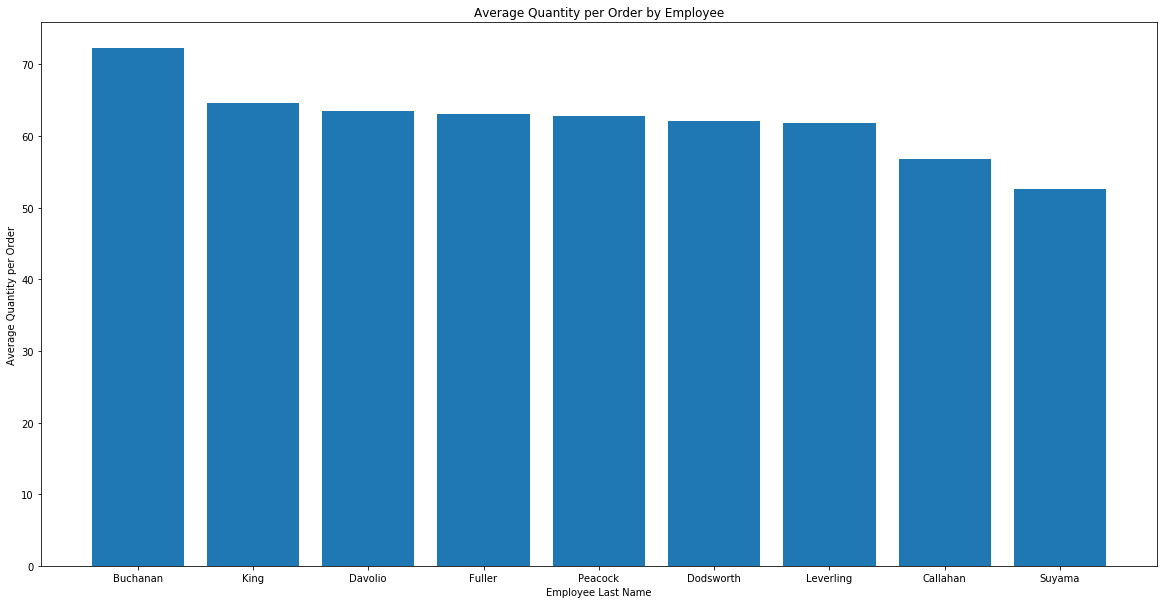

In [51]:
xs = sum_employee_orders_df['EmployeeID']
ys = sum_employee_orders_df['OrderQuantity']
names = []

for i in xs:
    last_name = list(Employee_df[Employee_df['Id']==i]['LastName'])[0]
    names.append(last_name)                 

print(names)
plt.figure(figsize=(20,10))
plt.bar(xs.sort_values(), ys)
plt.xticks(xs.sort_values(), names)
plt.title('Average Quantity per Order by Employee')
plt.xlabel('Employee Last Name')
plt.ylabel('Average Quantity per Order')

Here, we can see that Mr. Buchanan has the highest average quantity per order, with Michael Suyama in dead last. This reflects the result of our hypothesis test, which tells us that that is the only statistically significant difference between employee pairs.

['Dodsworth', 'Fuller', 'King', 'Buchanan', 'Leverling', 'Davolio', 'Peacock', 'Callahan', 'Suyama']


Text(0, 0.5, 'Average Revenue per Order')

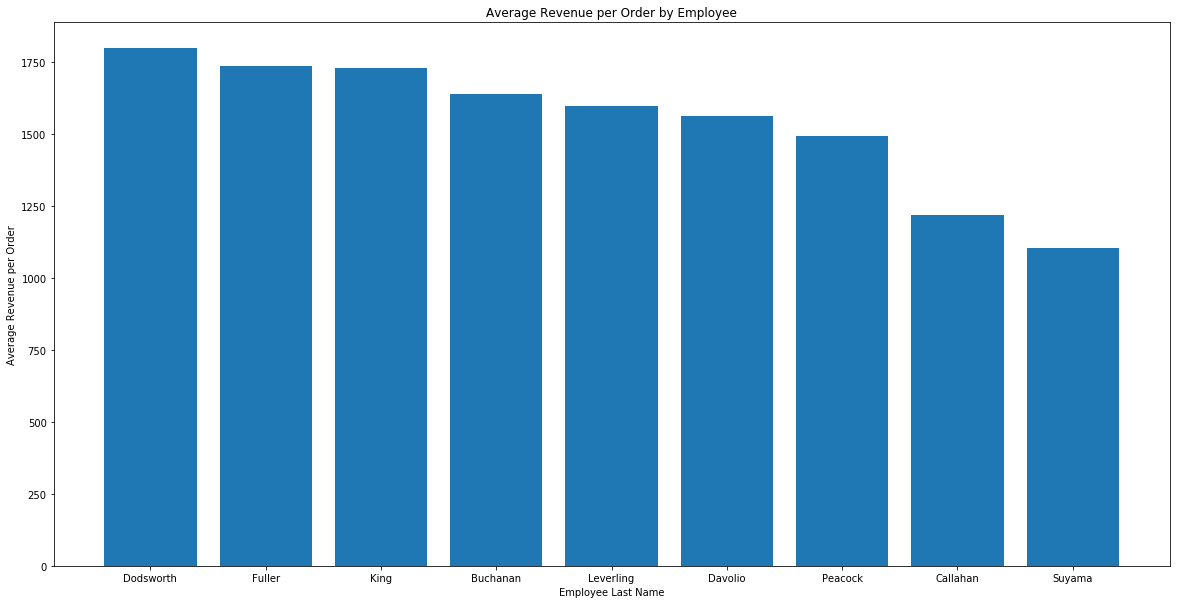

In [175]:
# Same graph, but for revenue instead of quantity
sum_employee_orders_df = sum_employee_orders_df.sort_values(by=['GrossRevenue'], ascending=False)
sum_employee_orders_df
xs = sum_employee_orders_df['EmployeeID']
ys = sum_employee_orders_df['GrossRevenue']
names = []

for i in xs:
    last_name = list(Employee_df[Employee_df['Id']==i]['LastName'])[0]
    names.append(last_name)                 

print(names)
plt.figure(figsize=(20,10))
plt.bar(xs.sort_values(), ys)
plt.xticks(xs.sort_values(), names)
plt.title('Average Revenue per Order by Employee')
plt.xlabel('Employee Last Name')
plt.ylabel('Average Revenue per Order')

In [174]:
sum_employee_orders_df

,EmployeeID,OrderQuantity,OrderID,GrossRevenue
8,9,62.093023,10725.418605,1797.862012
1,2,63.072917,10706.989583,1734.768281
6,7,64.638889,10672.361111,1730.114375
4,5,72.285714,10624.690476,1637.911488
2,3,61.826772,10662.622047,1596.951520
0,1,63.512195,10670.016260,1561.850443
3,4,62.807692,10638.903846,1492.890038
7,8,56.855769,10642.240385,1219.829591
5,6,52.641791,10643.835821,1103.181037


In [52]:
total_employee_orders_df = employee_orders_df.groupby(['EmployeeID'], as_index=False).count()
total_employee_orders_df = total_employee_orders_df.sort_values(by=['OrderQuantity'], ascending=False)
total_employee_orders_df

,EmployeeID,OrderQuantity,OrderID,GrossRevenue,LastName,Country
3,4,156,156,156,156,156
2,3,127,127,127,127,127
0,1,123,123,123,123,123
7,8,104,104,104,104,104
1,2,96,96,96,96,96
6,7,72,72,72,72,72
5,6,67,67,67,67,67
8,9,43,43,43,43,43
4,5,42,42,42,42,42


['Peacock', 'Leverling', 'Davolio', 'Callahan', 'Fuller', 'King', 'Suyama', 'Dodsworth', 'Buchanan']


Text(0, 0.5, 'Total Number of Orders Processed')

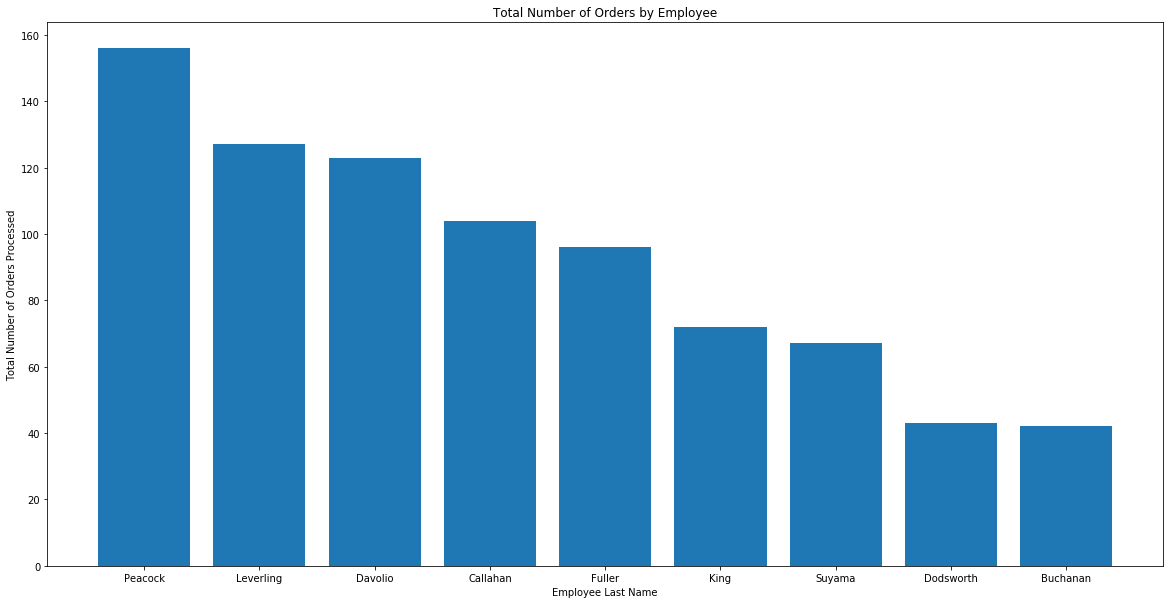

In [53]:
xs = total_employee_orders_df['EmployeeID']
ys = total_employee_orders_df['OrderQuantity']
names = []

for i in xs:
    last_name = list(Employee_df[Employee_df['Id']==i]['LastName'])[0]
    names.append(last_name)                 

print(names)
plt.figure(figsize=(20,10))
plt.bar(xs.sort_values(), ys)
plt.xticks(xs.sort_values(), names)
plt.title('Total Number of Orders by Employee')
plt.xlabel('Employee Last Name')
plt.ylabel('Total Number of Orders Processed')

# <font color='blue'> Part 2 Conclusion and Recommendations: Employees

**Results**

When comparing USA and UK employees, there does not seem to be any statistical difference between the two as groups. This holds true for both order quantity and gross revenue. However, when analyzing the employees on an individual basis, there were several very clear distinctions. 

Steven Buchanan seems to be the best performing employee from a quantity standpoint, having significantly more average quantity per order than the two seemingly worst employees: Michael Suyama and Laura Callahan.

**Recommendations**

Given his selling prowess, I suggest having Steven Buchanan lead a sales training course over a several week period. Attendance should be mandatory for Michael Suyama and Laura Callahan, and optional for all other sales people. I would also recommend implenting an incentive system so high performing employees can get recognized outside of 3rd party statistical analysis. 



#  <font color='green'> Part 3: Analyzing Shipping Companies

# Question 3a: Are there any significant differences in processing time and shipping time between the 3 shipping companies?

Here's we'll analyze if a certain shipping company differs from the others for average processing time: the time it takes to ship an order once an order has been placed, and average shipping time: the time from when an order is shipped to when it is required. 

In [55]:
# Getting rid of null values before analysis
Order_shipper_df = Order_df.copy()
Order_shipper_df.dropna(inplace=True)
Order_shipper_df.isna().sum()

Id                0
CustomerId        0
EmployeeId        0
OrderDate         0
RequiredDate      0
ShippedDate       0
ShipVia           0
Freight           0
ShipName          0
ShipAddress       0
ShipCity          0
ShipRegion        0
ShipPostalCode    0
ShipCountry       0
dtype: int64

In [56]:
# Then, converting the existing dates into datetime format
Order_shipper_df['OrderDate'] = pd.to_datetime(Order_shipper_df['OrderDate'])
Order_shipper_df['RequiredDate'] = pd.to_datetime(Order_shipper_df['RequiredDate'])
Order_shipper_df['ShippedDate'] = pd.to_datetime(Order_shipper_df['ShippedDate'])
Order_shipper_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 790 entries, 0 to 821
Data columns (total 14 columns):
Id                790 non-null int64
CustomerId        790 non-null object
EmployeeId        790 non-null int64
OrderDate         790 non-null datetime64[ns]
RequiredDate      790 non-null datetime64[ns]
ShippedDate       790 non-null datetime64[ns]
ShipVia           790 non-null int64
Freight           790 non-null float64
ShipName          790 non-null object
ShipAddress       790 non-null object
ShipCity          790 non-null object
ShipRegion        790 non-null object
ShipPostalCode    790 non-null object
ShipCountry       790 non-null object
dtypes: datetime64[ns](3), float64(1), int64(3), object(7)
memory usage: 92.6+ KB


In [57]:
# Creating new columns for processing time and shipping time.
processing_time_values = Order_shipper_df['ShippedDate'] - Order_shipper_df['OrderDate']
Order_shipper_df['ProcessingTime'] = (processing_time_values / np.timedelta64(1, 'D')).astype(int)

shipping_time_values = Order_shipper_df['RequiredDate'] - Order_shipper_df['ShippedDate']
Order_shipper_df['ShippingTime'] = (shipping_time_values / np.timedelta64(1, 'D')).astype(int)

Order_shipper_df.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,ProcessingTime,ShippingTime
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,12,16
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany,5,37
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil,4,24
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France,7,21
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium,2,26


In [63]:
Shipper_df

,Id,CompanyName,Phone
0,1,Speedy Express,(503) 555-9831
1,2,United Package,(503) 555-3199
2,3,Federal Shipping,(503) 555-9931


In [74]:
Order_shipper_df['ShipperName'] = ""
Order_shipper_df.loc[Order_shipper_df['ShipVia'] == 3, 'ShipperName'] = "Federal Shipping"
Order_shipper_df.loc[Order_shipper_df['ShipVia'] == 2, 'ShipperName'] = "United Package"
Order_shipper_df.loc[Order_shipper_df['ShipVia'] == 1, 'ShipperName'] = "Speedy Express"

In [139]:
# Checking for sufficient sample size and relatively close sample sizes
Order_shipper_df['ShipperName'].value_counts()

United Package      306
Federal Shipping    243
Speedy Express      241
Name: ShipperName, dtype: int64

Similar to what I did above for employees, here I will use welch's t-test to compare all combinations of shippers to each other for processing time

In [144]:
#First, I have to create different combinations to test. 

shipper_names = np.array(["Speedy Express", "United Package", "Federal Shipping"])
shipper_combinations = itertools.combinations(shipper_names, 2)

#Creating a dataframe to put the output of our test in
shipper_processing_combo_df = pd.DataFrame(columns = ['Shipper 1','Shipper 2','p-value',
                                                      'Reject Null?', 'Shipper 1 Processing Mean', 'Shipper 2 Processing Mean',
                                                      'Effect Size', 'Cohens d'])

for combo in shipper_combinations:
    
    samp1_control = Order_shipper_df[Order_shipper_df['ShipperName']==combo[0]]['ProcessingTime']
    samp2_experimental = Order_shipper_df[Order_shipper_df['ShipperName']==combo[1]]['ProcessingTime']
    
    s1mean = Order_shipper_df[Order_shipper_df['ShipperName']==combo[0]]['ProcessingTime'].mean()
    s2mean = Order_shipper_df[Order_shipper_df['ShipperName']==combo[1]]['ProcessingTime'].mean()
    
    t_stat, p_val = stats.ttest_ind(samp2_experimental, samp1_control)
    effect_size_quantity = round(samp2_experimental.mean() - samp1_control.mean(),2)
    effect_size_cohen = round(Cohen_d(samp2_experimental, samp1_control),3)
    
    shipper_processing_combo_df = shipper_processing_combo_df.append({'Shipper 1' : combo[0], 'Shipper 2': combo[1], 
                                                 'p-value': p_val, 'Reject Null?': "Yes, Reject" if p_val < 0.05 else "No, Fail to Reject",
                                                           'Shipper 1 Processing Mean': s1mean, 'Shipper 2 Processing Mean': s2mean,
                                                 'Effect Size': effect_size_quantity, 'Cohens d': effect_size_cohen}, ignore_index=True)


In [145]:
shipper_names = np.array(["Speedy Express", "United Package", "Federal Shipping"])
shipper_combinations = itertools.combinations(shipper_names, 2)

shipper_shipping_combo_df = pd.DataFrame(columns = ['Shipper 1','Shipper 2','p-value',
                                                      'Reject Null?', 'Shipper 1 Shipping Mean', 'Shipper 2 Shipping Mean',
                                                      'Effect Size', 'Cohens d'])

for combo in shipper_combinations:
    
    samp1_control = Order_shipper_df[Order_shipper_df['ShipperName']==combo[0]]['ShippingTime']
    samp2_experimental = Order_shipper_df[Order_shipper_df['ShipperName']==combo[1]]['ShippingTime']
    
    s1mean = Order_shipper_df[Order_shipper_df['ShipperName']==combo[0]]['ShippingTime'].mean()
    s2mean = Order_shipper_df[Order_shipper_df['ShipperName']==combo[1]]['ShippingTime'].mean()
    
    t_stat, p_val = stats.ttest_ind(samp2_experimental, samp1_control)
    effect_size_quantity = round(samp2_experimental.mean() - samp1_control.mean(),2)
    effect_size_cohen = round(Cohen_d(samp2_experimental, samp1_control),3)
    
    shipper_shipping_combo_df = shipper_shipping_combo_df.append({'Shipper 1' : combo[0], 'Shipper 2': combo[1], 
                                                 'p-value': p_val, 'Reject Null?': "Yes, Reject" if p_val < 0.05 else "No, Fail to Reject",
                                                           'Shipper 1 Shipping Mean': s1mean, 'Shipper 2 Shipping Mean': s2mean,
                                                 'Effect Size': effect_size_quantity, 'Cohens d': effect_size_cohen}, ignore_index=True)

In [146]:
shipper_processing_combo_df

,Shipper 1,Shipper 2,p-value,Reject Null?,Shipper 1 Processing Mean,Shipper 2 Processing Mean,Effect Size,Cohens d
0,Speedy Express,United Package,0.256429,"No, Fail to Reject",8.497925,9.199346,0.7,0.098
1,Speedy Express,Federal Shipping,0.046804,"Yes, Reject",8.497925,7.399177,-1.1,-0.181
2,United Package,Federal Shipping,0.001920,"Yes, Reject",9.199346,7.399177,-1.8,-0.268


In [147]:
shipper_shipping_combo_df

,Shipper 1,Shipper 2,p-value,Reject Null?,Shipper 1 Shipping Mean,Shipper 2 Shipping Mean,Effect Size,Cohens d
0,Speedy Express,United Package,0.312286,"No, Fail to Reject",19.560166,18.754902,-0.81,-0.087
1,Speedy Express,Federal Shipping,0.554604,"No, Fail to Reject",19.560166,20.024691,0.46,0.054
2,United Package,Federal Shipping,0.086548,"No, Fail to Reject",18.754902,20.024691,1.27,0.148


**Results**

The results of testing suggest that Federal Shipping has a significant advantage over the two other shipping companies in processing time. There is no significant difference between the companies on the issue of shipping time. 

# Question 3b: Are there differences between freights costs among shippers?

In [161]:
shipper_names = np.array(["Speedy Express", "United Package", "Federal Shipping"])
shipper_combinations = itertools.combinations(shipper_names, 2)

shipper_freight_combo_df = pd.DataFrame(columns = ['Shipper 1','Shipper 2','p-value',
                                                      'Reject Null?', 'Shipper 1 Freight Mean', 'Shipper 2 Freight Mean',
                                                      'Effect Size', 'Cohens d'])

for combo in shipper_combinations:
    
    samp1_control = Order_shipper_df[Order_shipper_df['ShipperName']==combo[0]]['Freight']
    samp2_experimental = Order_shipper_df[Order_shipper_df['ShipperName']==combo[1]]['Freight']
    
    s1mean = Order_shipper_df[Order_shipper_df['ShipperName']==combo[0]]['Freight'].mean()
    s2mean = Order_shipper_df[Order_shipper_df['ShipperName']==combo[1]]['Freight'].mean()
    
    t_stat, p_val = stats.ttest_ind(samp2_experimental, samp1_control)
    effect_size_quantity = round(samp2_experimental.mean() - samp1_control.mean(),2)
    effect_size_cohen = round(Cohen_d(samp2_experimental, samp1_control),3)
    
    p_val = p_val / 2 # for one tailed test
    
    shipper_freight_combo_df = shipper_freight_combo_df.append({'Shipper 1' : combo[0], 'Shipper 2': combo[1], 
                                                 'p-value': p_val, 'Reject Null?': "Yes, Reject" if p_val < 0.05 else "No, Fail to Reject",
                                                           'Shipper 1 Freight Mean': s1mean, 'Shipper 2 Freight Mean': s2mean,
                                                 'Effect Size': effect_size_quantity, 'Cohens d': effect_size_cohen}, ignore_index=True)

In [162]:
shipper_freight_combo_df

,Shipper 1,Shipper 2,p-value,Reject Null?,Shipper 1 Freight Mean,Shipper 2 Freight Mean,Effect Size,Cohens d
0,Speedy Express,United Package,0.029475,"Yes, Reject",65.445851,83.876961,18.43,0.163
1,Speedy Express,Federal Shipping,0.042836,"Yes, Reject",65.445851,81.320905,15.88,0.157
2,United Package,Federal Shipping,0.409051,"No, Fail to Reject",83.876961,81.320905,-2.56,-0.020


**Results**

Speedy express has a lower freight mean than the other two shippers by a statistically significant amount. As both p-values are below our alpha = 0.05, we reject the null hypothesis that there is no difference in mean freight price between speedy and the other two shippers.

# <font color='blue'> Part 3 Conclusion and Recommendations: Shipping Companies

**Results**

When comparing processing time, I learned that Federal Shipping has a significantly faster processing time than the other two shipping companies. However, when comparing shipping times there was no significant difference.

On the issue of cost, Speedy Express had a significantly lower average freight amount than the other two shippers. 

**Recommendations**

These results should be leveraged in future negotiations with shipping companies. Particularly processing time, which should be relatively consistent across all 3, is dominated by Federal Shipping. Further investigation is needed to determine the cause of this, but other shipper should be held to the same processing time standard as Federal Shipping.

The cost savings of Speedy Express should also be leveraged in negotiations with the other two shipping companies.  



#  <font color='green'> Part 4: Customer Analysis

In [178]:
Order_df['CustomerId'].unique()

array(['VINET', 'TOMSP', 'HANAR', 'VICTE', 'SUPRD', 'CHOPS', 'RICSU',
       'WELLI', 'HILAA', 'ERNSH', 'CENTC', 'OTTIK', 'QUEDE', 'RATTC',
       'FOLKO', 'BLONP', 'WARTH', 'FRANK', 'GROSR', 'WHITC', 'SPLIR',
       'QUICK', 'MAGAA', 'TORTU', 'MORGK', 'BERGS', 'LEHMS', 'ROMEY',
       'LILAS', 'RICAR', 'REGGC', 'BSBEV', 'COMMI', 'TRADH', 'HUNGO',
       'WANDK', 'GODOS', 'OLDWO', 'LONEP', 'ANATR', 'THEBI', 'DUMO',
       'ISLAT', 'PERIC', 'KOENE', 'SAVEA', 'BOLID', 'FURIB', 'BONAP',
       'MEREP', 'PRINI', 'SIMOB', 'FAMIA', 'LAMAI', 'PICCO', 'AROUT',
       'SEVES', 'DRACD', 'EASTC', 'ANTO', 'GALED', 'VAFFE', 'QUEE',
       'WOLZA', 'HUNGC', 'SANTG', 'BOTTM', 'LINOD', 'FOLIG', 'OCEA',
       'FRANS', 'GOURL', 'CONSH', 'RANCH', 'LAZYK', 'LAUGB', 'BLAUS',
       'NORTS', 'CACTU', 'GREAL', 'MAISD', 'TRAIH', 'LETSS', 'WILMK',
       'THECR', 'ALFKI', 'FRANR', 'SPECD', 'LACOR'], dtype=object)

In [182]:
Order_df.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [183]:
Customer_df.head()

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67


In [187]:
# Using SQL statements to get a table showing order, order quantity total, and the employee region for each order
customer_query = """SELECT asdf.CustomerID,
                              asdf.OrderQuantity,
                              asdf.OrderID,
                              asdf.GrossRevenue,
                              c.CompanyName,
                              c.Country,
                              c.Region
                              
                    FROM (
                        SELECT o.CustomerId AS CustomerID,
                            o.Id as OrderID,
                            SUM(od.Quantity) AS OrderQuantity,
                            SUM((od.Quantity*od.UnitPrice)*(1-od.Discount)) as GrossRevenue
                            FROM [Order] o
                            INNER JOIN OrderDetail od ON o.Id == od.OrderId
                                
                            GROUP BY o.Id
                            ) asdf
                    INNER JOIN Customer c ON c.Id = asdf.CustomerID
                       
                    """

In [188]:
customer_orders_df = pd.read_sql_query(customer_query, engine)
customer_orders_df

2019-04-10 13:41:34,076 INFO sqlalchemy.engine.base.Engine SELECT asdf.CustomerID,
                              asdf.OrderQuantity,
                              asdf.OrderID,
                              asdf.GrossRevenue,
                              c.CompanyName,
                              c.Country,
                              c.Region
                              
                    FROM (
                        SELECT o.CustomerId AS CustomerID,
                            o.Id as OrderID,
                            SUM(od.Quantity) AS OrderQuantity,
                            SUM((od.Quantity*od.UnitPrice)*(1-od.Discount)) as GrossRevenue
                            FROM [Order] o
                            INNER JOIN OrderDetail od ON o.Id == od.OrderId
                                
                            GROUP BY o.Id
                            ) asdf
                    INNER JOIN Customer c ON c.Id = asdf.CustomerID
                       
           

,CustomerID,OrderQuantity,OrderID,GrossRevenue,CompanyName,Country,Region
0,VINET,27,10248,440.0000,Vins et alcools Chevalier,France,Western Europe
1,TOMSP,49,10249,1863.4000,Toms Spezialitäten,Germany,Western Europe
2,HANAR,60,10250,1552.6000,Hanari Carnes,Brazil,South America
3,VICTE,41,10251,654.0600,Victuailles en stock,France,Western Europe
4,SUPRD,105,10252,3597.9000,Suprêmes délices,Belgium,Western Europe
5,HANAR,102,10253,1444.8000,Hanari Carnes,Brazil,South America
6,CHOPS,57,10254,556.6200,Chop-suey Chinese,Switzerland,Western Europe
7,RICSU,110,10255,2490.5000,Richter Supermarkt,Switzerland,Western Europe
8,WELLI,27,10256,517.8000,Wellington Importadora,Brazil,South America
9,HILAA,46,10257,1119.9000,HILARION-Abastos,Venezuela,South America


In [191]:
# Checking sample sizes before regional comparison
customer_orders_df['Region'].value_counts()

Western Europe     272
North America      152
South America      127
British Isles       75
Southern Europe     64
Northern Europe     55
Scandinavia         28
Central America     21
Eastern Europe       7
Name: Region, dtype: int64

In [199]:
customer_orders_df.dropna(inplace=True)

Performing a welch's t-test on samples with less than 30 items has been proven to skew results. As such, Scandinavia, Central America, and Eastern Europe will be excluded from this analysis.

In [202]:
# T-test for quantity average quantity ordered from each region
region_names = np.array(['Western Europe', 'North America', 'South America', 'British Isles', 'Southern Europe', 'Northern Europe'])
region_combinations = itertools.combinations(region_names, 2)

region_combo_df = pd.DataFrame(columns = ['Region 1','Region 2','p-value',
                                                      'Reject Null?', 'Region 1 Quantity Mean', 'Region 2 Quantity Mean',
                                                      'Effect Size', 'Cohens d'])

for combo in region_combinations:
    
    samp1_control = customer_orders_df[customer_orders_df['Region']==combo[0]]['OrderQuantity']
    samp2_experimental = customer_orders_df[customer_orders_df['Region']==combo[1]]['OrderQuantity']
    
    s1mean = customer_orders_df[customer_orders_df['Region']==combo[0]]['OrderQuantity'].mean()
    s2mean = customer_orders_df[customer_orders_df['Region']==combo[1]]['OrderQuantity'].mean()
    
    t_stat, p_val = stats.ttest_ind(samp2_experimental, samp1_control)
    effect_size_quantity = round(samp2_experimental.mean() - samp1_control.mean(),2)
    effect_size_cohen = round(Cohen_d(samp2_experimental, samp1_control),3)
    
    p_val = p_val / 2 # for one tailed test
    
    region_combo_df = region_combo_df.append({'Region 1' : combo[0], 'Region 2': combo[1], 
                                                 'p-value': p_val, 'Reject Null?': "Yes, Reject" if p_val < 0.05 else "No, Fail to Reject",
                                                           'Region 1 Quantity Mean': s1mean, 'Region 2 Quantity Mean': s2mean,
                                                 'Effect Size': effect_size_quantity, 'Cohens d': effect_size_cohen}, ignore_index=True)

In [206]:
region_combo_df[region_combo_df['Reject Null?'] == "Yes, Reject"]

,Region 1,Region 2,p-value,Reject Null?,Region 1 Quantity Mean,Region 2 Quantity Mean,Effect Size,Cohens d
1,Western Europe,South America,7.803652e-06,"Yes, Reject",74.341912,50.070866,-24.27,-0.470
2,Western Europe,British Isles,1.666500e-02,"Yes, Reject",74.341912,59.013333,-15.33,-0.279
3,Western Europe,Southern Europe,2.220188e-08,"Yes, Reject",74.341912,32.390625,-41.95,-0.779
5,North America,South America,5.052656e-05,"Yes, Reject",74.434211,50.070866,-24.36,-0.474
6,North America,British Isles,2.702156e-02,"Yes, Reject",74.434211,59.013333,-15.42,-0.273
7,North America,Southern Europe,2.989752e-07,"Yes, Reject",74.434211,32.390625,-42.04,-0.768
9,South America,British Isles,3.943430e-02,"Yes, Reject",50.070866,59.013333,8.94,0.257
10,South America,Southern Europe,7.645874e-05,"Yes, Reject",50.070866,32.390625,-17.68,-0.593
11,South America,Northern Europe,1.444356e-02,"Yes, Reject",50.070866,61.909091,11.84,0.355
12,British Isles,Southern Europe,3.597569e-06,"Yes, Reject",59.013333,32.390625,-26.62,-0.794


We have a number of significant results from our combination hypothesis testing. It appears that **Western Europe and North America are performing the strongest**, with testing illustrtating a significant difference between both of these regions and most other regions. 

While these are the highest performing regions, we can also see some areas which are underperforming. **South America, the British Isles, and Southern Europe all have significantly lower means than their comparisons.** 

Below, I perform the same analysis but for sales dollars instead of quantity.

In [207]:
# T-test for quantity average sales revenue per order from each region
region_names = np.array(['Western Europe', 'North America', 'South America', 'British Isles', 'Southern Europe', 'Northern Europe'])
region_combinations = itertools.combinations(region_names, 2)

region_sales_combo_df = pd.DataFrame(columns = ['Region 1','Region 2','p-value',
                                                      'Reject Null?', 'Region 1 Sales Mean', 'Region 2 Sales Mean',
                                                      'Effect Size', 'Cohens d'])

for combo in region_combinations:
    
    samp1_control = customer_orders_df[customer_orders_df['Region']==combo[0]]['GrossRevenue']
    samp2_experimental = customer_orders_df[customer_orders_df['Region']==combo[1]]['GrossRevenue']
    
    s1mean = customer_orders_df[customer_orders_df['Region']==combo[0]]['GrossRevenue'].mean()
    s2mean = customer_orders_df[customer_orders_df['Region']==combo[1]]['GrossRevenue'].mean()
    
    t_stat, p_val = stats.ttest_ind(samp2_experimental, samp1_control)
    effect_size_quantity = round(samp2_experimental.mean() - samp1_control.mean(),2)
    effect_size_cohen = round(Cohen_d(samp2_experimental, samp1_control),3)
    
    p_val = p_val / 2 # for one tailed test
    
    region_sales_combo_df = region_sales_combo_df.append({'Region 1' : combo[0], 'Region 2': combo[1], 
                                                 'p-value': p_val, 'Reject Null?': "Yes, Reject" if p_val < 0.05 else "No, Fail to Reject",
                                                           'Region 1 Sales Mean': s1mean, 'Region 2 Sales Mean': s2mean,
                                                 'Effect Size': effect_size_quantity, 'Cohens d': effect_size_cohen}, ignore_index=True)

In [209]:
region_sales_combo_df[region_sales_combo_df['Reject Null?'] == "Yes, Reject"]

,Region 1,Region 2,p-value,Reject Null?,Region 1 Sales Mean,Region 2 Sales Mean,Effect Size,Cohens d
1,Western Europe,South America,0.000207,"Yes, Reject",1851.280914,1123.447307,-727.83,-0.383
3,Western Europe,Southern Europe,0.000008,"Yes, Reject",1851.280914,706.651836,-1144.63,-0.610
5,North America,South America,0.000226,"Yes, Reject",1945.926977,1123.447307,-822.48,-0.427
6,North America,British Isles,0.043560,"Yes, Reject",1945.926977,1452.682867,-493.24,-0.243
7,North America,Southern Europe,0.000009,"Yes, Reject",1945.926977,706.651836,-1239.28,-0.654
10,South America,Southern Europe,0.019748,"Yes, Reject",1123.447307,706.651836,-416.80,-0.318
11,South America,Northern Europe,0.036844,"Yes, Reject",1123.447307,1584.657500,461.21,0.290
12,British Isles,Southern Europe,0.000438,"Yes, Reject",1452.682867,706.651836,-746.03,-0.579
14,Southern Europe,Northern Europe,0.000172,"Yes, Reject",706.651836,1584.657500,878.01,0.678


Similar to the quantity analysis, these results also indicate that Western Europe and North America are outperforming South America, Southern Europe. Furthermore, North America is also outperforming the British Isles by a significant margin. 

# <font color='blue'> Part 4 Conclusion and Recommendations: Customer Analysis

**Results**

When comparing the regions, we determined that the largest and most profitable orders come from North America and Western Europe. We also learned that orders in Southern Europe, Northern Europe, and the British Isles are typically smaller. 

**Recommendations**

More rapport with customers needs to be built within Southern and Northern Europe. Additionally, more time should be spent on these customers because typically their orders are smaller. I would recommend hiring a product manager who has experience in those regions to help boost sales there. 



# <font color='green'> Future Work
   

1. The biggest future work revolves around profitability. Since there was no way to determine the cost of goods sold (what it cost the company to buy the thing that is sold), I could only make inferences about total revenue and not profit. Ideally, I'd be able to analyze the profitability of each order so that I could evaluate each order on its contribution to the company's overall financial health.
2. I'd like to make employee evaluation metrics annual or monthly. Instead of seeing their total orders place, seeing the number of sales each employee has per year since they started with the company. This would allow me to evaluate the growth progression of employees, and identify employees who need additional help. 
3. Determine if order size has an effect on processing and shipping time, and if certain shippers have better response times for different sized orders.
4. Analyze the roles of the customer contacts to see if certain customer contacts with different titles order different quantities of product.